<a href="https://www.kaggle.com/code/ricktenbult/power-consumption-forecasting?scriptVersionId=135502833" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Context
Forecasting hourly power consumption using data is beneficial for several reasons. Firstly, it allows power companies to plan and optimize their electricity generation and distribution resources more efficiently, ensuring a stable and reliable power supply. Secondly, it helps in managing peak demand periods by identifying potential spikes in power consumption and implementing strategies to mitigate them. Thirdly, accurate forecasting enables better demand-response programs, where consumers can adjust their electricity usage based on predicted peak hours, leading to cost savings and reduced strain on the grid. Lastly, it aids in promoting energy conservation and sustainability by providing insights into consumption patterns and encouraging more efficient energy use.

## Content
The dataset contains 145,366 rows and 2 attributes. The feature set includes:
* Datetime: The date and time - ranging from January 2002 to August 2018.
* PJME_MW: The hourly energy consumption.

In [1]:
# Import libraries
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Import performance metrics libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Import time forecasting libary
from prophet import Prophet 

In [2]:
# Load the dataset
data = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv", index_col=[0], parse_dates=[0])

# Create a copy of the dataset
df = data.copy()

# Sort the dataset
df.sort_index(inplace=True)

In [3]:
# Print the shape of the dataset
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset has 145366 rows and 1 columns.


In [4]:
# Show the first 5 rows of the dataset
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


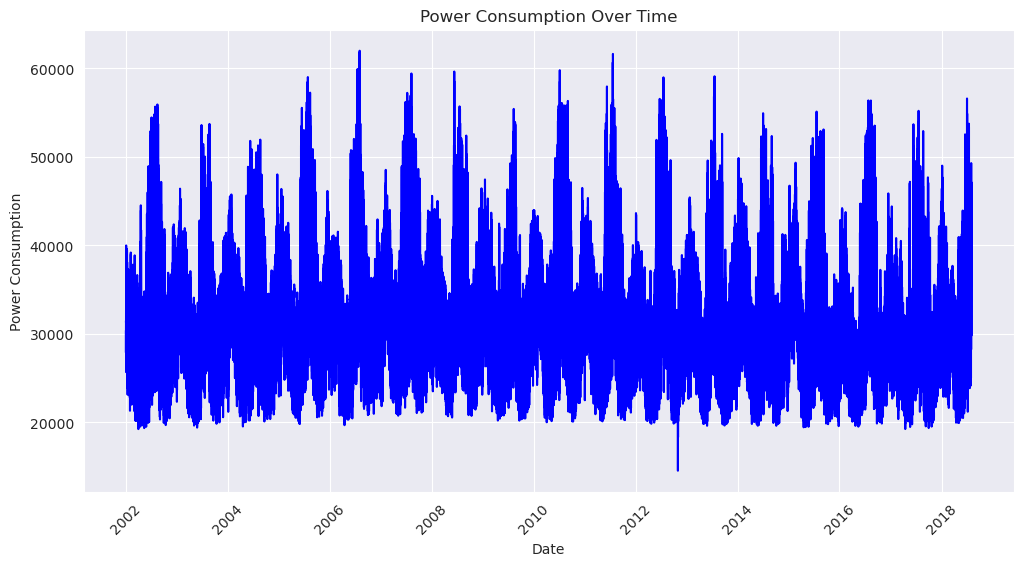

In [5]:
# Set the figure size and layout
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot the power consumption over time
sns.lineplot(data=df, x="Datetime", y="PJME_MW", color="b")

# Set labels and title
plt.title("Power Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.xticks(rotation=45)

# Display the plot
plt.show()

Based on the figure above, it can be determined that the dataset contains a few outliers, which are approximately greater than 50,000 MW, and a single outlier which is significantly smaller than approximately 20,000 MW. These outliers will be replaced with the mean of the column to improve the performance of the time series analysis.

In [6]:
def replace_outliers(df: pd.DataFrame, column: str, inner_fence_multiplier: float = 1.5, outer_fence_multiplier: float = 3.0) -> pd.DataFrame:
    """
    Function used to replace outliers in each continuous column with the mean value.

    Parameters:
        - df (pd.DataFrame): A DataFrame containing the data.
        - column (str): A column to be processed.
        - inner_fence_multiplier (float): A multiplier to determine the inner fence. Default is 1.5.
        - outer_fence_multiplier (float): A multiplier to determine the outer fence. Default is 3.0.

    Returns:
        - df (pd.DataFrame): A DataFrame with outliers replaced by the mean value.
    """

    # Calculate the Interquartile Range (IQR)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the inner and outer fences
    inner_fence_low = Q1 - inner_fence_multiplier * IQR
    inner_fence_high = Q3 + inner_fence_multiplier * IQR
    outer_fence_low = Q1 - outer_fence_multiplier * IQR
    outer_fence_high = Q3 + outer_fence_multiplier * IQR

    # Identify the outliers using the inner and outer fences
    outliers = (df[column] < inner_fence_low) | (df[column] > inner_fence_high) | \
               (df[column] < outer_fence_low) | (df[column] > outer_fence_high)

    # Replace the outliers with the mean value
    df.loc[outliers, column] = df[column].mean()

    # Replace values smaller than 19,000 with the mean value
    # Based on experience, the values smaller than 19,000 do not get considered as outliers
    df.loc[df["PJME_MW"] < 19000, "PJME_MW"] = df["PJME_MW"].mean()


    return df

In [7]:
# Apply the replace_outliers function to the dataset
df = replace_outliers(df, column="PJME_MW")

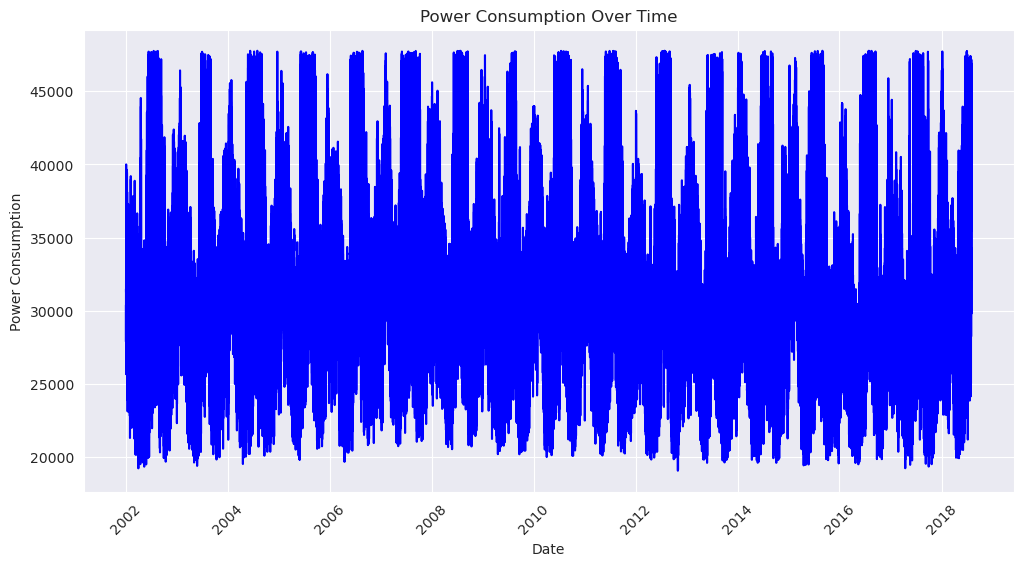

In [8]:
# Set the figure size and layout
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot the power consumption over time
sns.lineplot(data=df, x="Datetime", y="PJME_MW", color="b")

# Set labels and title
plt.title("Power Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [9]:
def add_date_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function used to add date-related columns to a DataFrame based on a datetime index.

    Parameters:
        - df (pd.DataFrame): A DataFrame with a datetime index.

    Returns:
        - df (pd.DataFrame): A DataFrame with additional date-related columns.
    """
    
    # Define the calendar
    cal = calendar()
    
    # Add date-related columns
    df["Date"] = df.index.date
    df["Hour"] = df.index.hour
    df["DayofWeek"] = df.index.dayofweek
    df["Month"] = df.index.month
    df["Quarter"] = df.index.quarter
    df["DayofYear"] = df.index.dayofyear
    df["Year"] = df.index.year
    df["Season"] = df.index.quarter.map(lambda x: {1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"}.get(x))
    df["Holiday"] = df["Date"].isin([date.date() for date in cal.holidays()])
   

    return df

In [10]:
# Apply the add_date_columns function
df = add_date_columns(df)

In [11]:
# Convert the "Date" column to a datetime type
df["Date"] = pd.to_datetime(df["Date"])

In [12]:
# Show the first 5 rows of the dataset
df.head()

,PJME_MW,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,Holiday
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002-01-01,1,1,1,1,1,2002,Winter,True
2002-01-01 02:00:00,29265.0,2002-01-01,2,1,1,1,1,2002,Winter,True
2002-01-01 03:00:00,28357.0,2002-01-01,3,1,1,1,1,2002,Winter,True
2002-01-01 04:00:00,27899.0,2002-01-01,4,1,1,1,1,2002,Winter,True
2002-01-01 05:00:00,28057.0,2002-01-01,5,1,1,1,1,2002,Winter,True


In [13]:
# Show the last 5 rows of the dataset
df.tail()

,PJME_MW,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,Holiday
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,2018-08-02,20,3,8,3,214,2018,Summer,False
2018-08-02 21:00:00,43256.0,2018-08-02,21,3,8,3,214,2018,Summer,False
2018-08-02 22:00:00,41552.0,2018-08-02,22,3,8,3,214,2018,Summer,False
2018-08-02 23:00:00,38500.0,2018-08-02,23,3,8,3,214,2018,Summer,False
2018-08-03 00:00:00,35486.0,2018-08-03,0,4,8,3,215,2018,Summer,False


In [14]:
def visualizations(df: pd.DataFrame):
    """
    Function used to plot boxplots for each selected column.

    Parameters:
        - df (pd.DataFrame): A DataFrame containing the data.
    """

    # Select the columns to be visualized
    columns = ["Hour", "DayofWeek", "Month", "Quarter", "Year", "Season", "Holiday"]
    
    # Set the figure size and layout
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(12, 6 * len(columns)))
    plt.tight_layout(pad=2.0)
    
    for index, column in enumerate(columns):
        # Plot boxplot
        sns.boxplot(data=df, x=column, y="PJME_MW", ax=axes[index], palette="blend:#7AB,#EDA")
        axes[index].set_title(f"Boxplot of {column}")
        axes[index].set_xlabel("")

    # Show the plot
    plt.show()

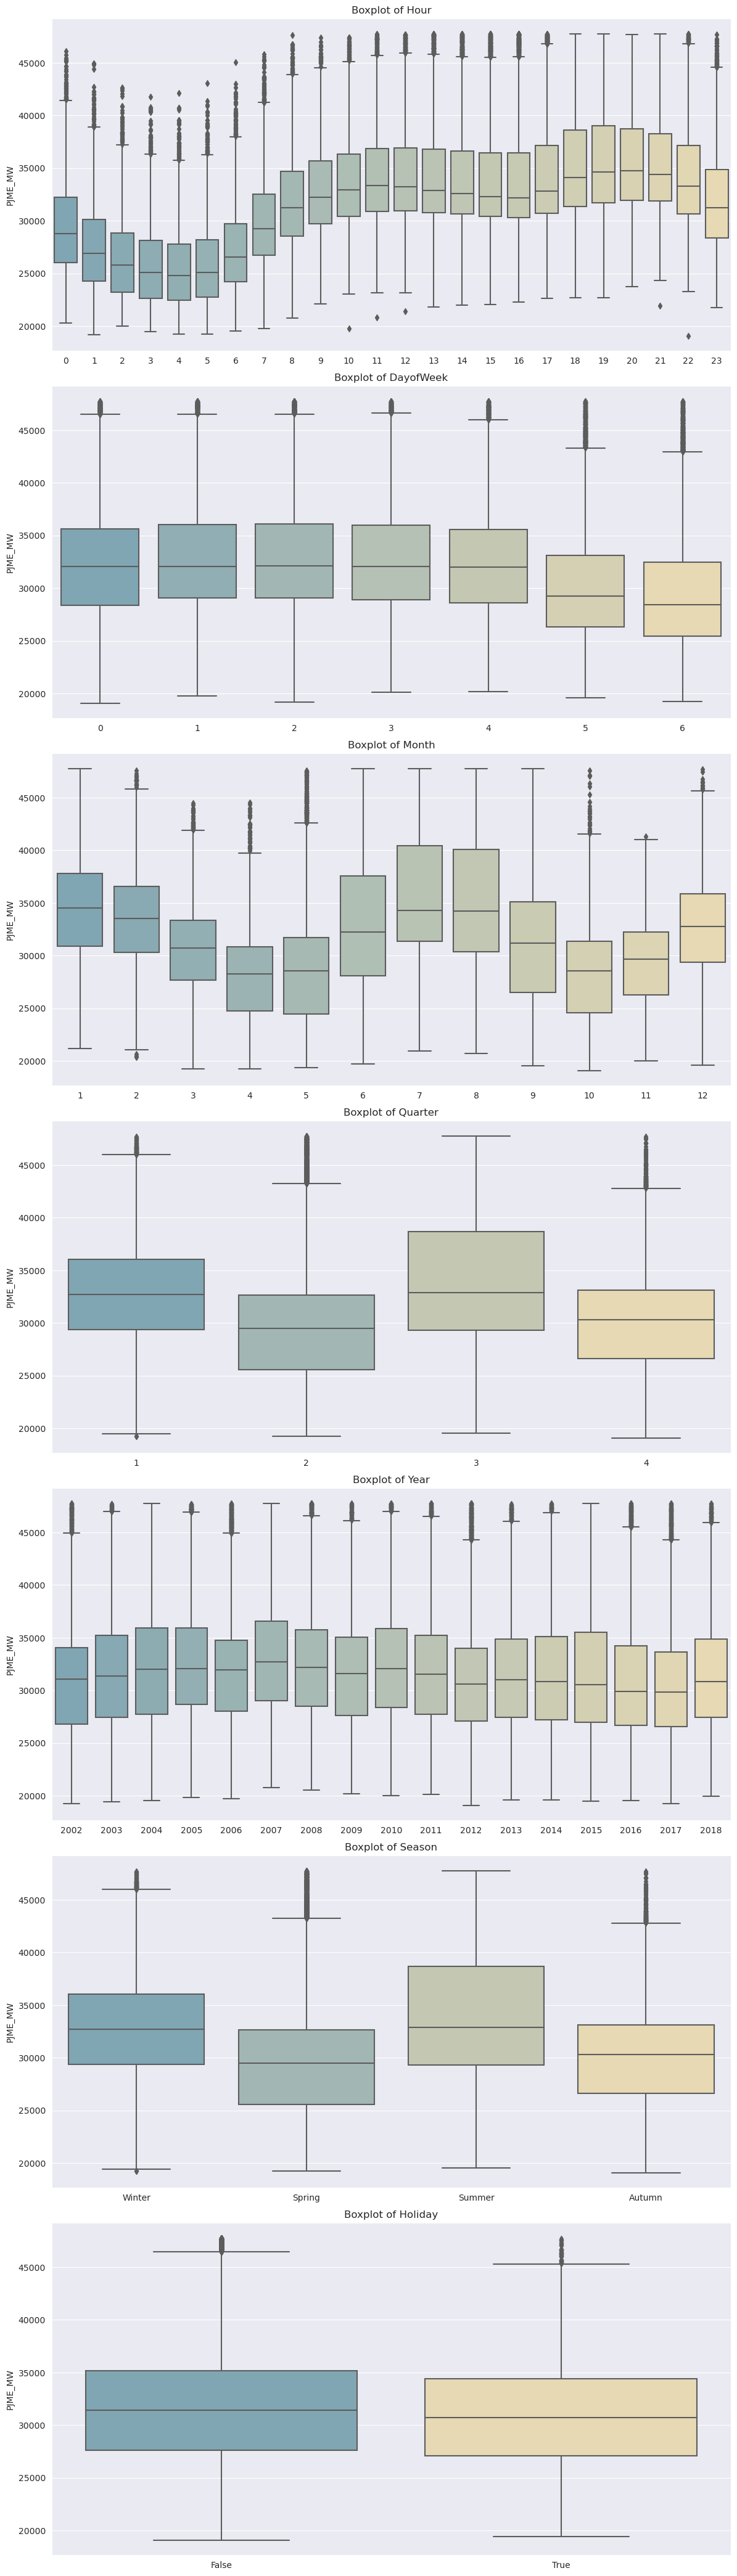

In [15]:
# Apply the visualizations function
visualizations(df)

A number of conclusions can be drawn on the basis of the above figures. First, the hourly power consumption peaks between 6 and 9 p.m., which is in line with what I would expect. Second, the power consumption per day shows a decrease over the weekend, which I wouldn't expect since people will be home more during the weekend than during the week. Third, electricity consumption per month, quarter, and season shows an increase during the summer months, which can be explained by people wanting to cool their homes. Finally, the power consumption per year and holiday show no significant differences.

In [16]:
def split_datasets(df: pd.DataFrame, threshold_date: str) -> pd.DataFrame:
    """
    Function used to split a DataFrame into train and test DataFrames based on a given threshold date.

    Args:
        df (pd.DataFrame): A original DataFrame.
        threshold_date (str): A threshold date in "YYYY-MM-DD" format.

    Returns:
        df(pd.DataFrame): A tuple containing the train DataFrame and test DataFrame.
    """

    # Convert the treshold date to datetime if needed
    threshold_date = datetime.strptime(threshold_date, "%Y-%m-%d")  
    
    # Split the DataFrame into train and test DataFrames based on the treshold date
    train_df = df[df.index < threshold_date].copy()
    test_df = df[df.index >= threshold_date].copy()
    

    return train_df, test_df

In [17]:
# Apply the split_datasets function
train_df, test_df = split_datasets(df, "2015-01-01")

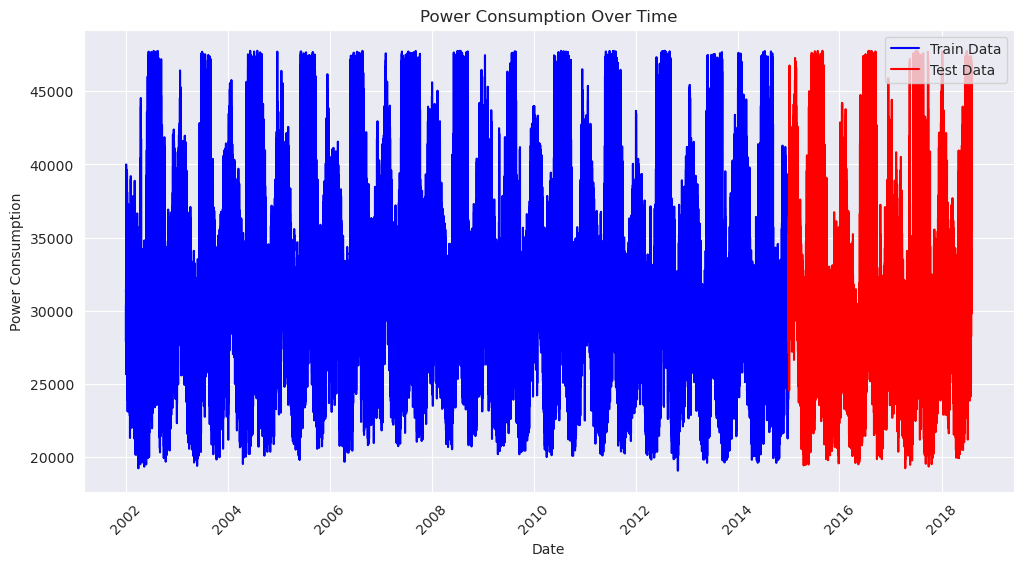

In [18]:
# Set the figure size and layout
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot the power consumption of the train dataset over time
sns.lineplot(data=train_df, x="Datetime", y="PJME_MW", label="Train Data", color="b")

# Plot the power consumption of the test dataset over time
sns.lineplot(data=test_df, x="Datetime", y="PJME_MW", label="Test Data", color="r")

# Set labels and title
plt.title("Power Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.xticks(rotation=45)

# Display the plot
plt.show()

The figure above visualizes the power consumption, which is broken down into train and test data based on a threshold. The trend for both the train and test data appears to be consistent, aiding in the analysis.

In [19]:
# Show the last 5 rows of the train dataset
train_df.tail()

,PJME_MW,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,Holiday
Datetime,,,,,,,,,,
2014-12-31 19:00:00,38906.0,2014-12-31,19,2,12,4,365,2014,Autumn,False
2014-12-31 20:00:00,37772.0,2014-12-31,20,2,12,4,365,2014,Autumn,False
2014-12-31 21:00:00,36602.0,2014-12-31,21,2,12,4,365,2014,Autumn,False
2014-12-31 22:00:00,35326.0,2014-12-31,22,2,12,4,365,2014,Autumn,False
2014-12-31 23:00:00,34003.0,2014-12-31,23,2,12,4,365,2014,Autumn,False


In [20]:
# Show the first 5 rows of the test dataset
test_df.head()

,PJME_MW,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,Holiday
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,2015-01-01,0,3,1,1,1,2015,Winter,True
2015-01-01 01:00:00,31647.0,2015-01-01,1,3,1,1,1,2015,Winter,True
2015-01-01 02:00:00,30755.0,2015-01-01,2,3,1,1,1,2015,Winter,True
2015-01-01 03:00:00,30189.0,2015-01-01,3,3,1,1,1,2015,Winter,True
2015-01-01 04:00:00,29890.0,2015-01-01,4,3,1,1,1,2015,Winter,True


In [21]:
# Format the train dataset
train_prophet = train_df.reset_index().rename(columns=
    {
    "Datetime":"ds",
    "PJME_MW":"y"
    })

# Format the test dataset
test_prophet = test_df.reset_index().rename(columns=
    {
    "Datetime":"ds",
    "PJME_MW":"y"
    })

In [22]:
# Create a DataFrame for the holidays
holiday_df = df.loc[df["Holiday"]].reset_index().rename(columns={"Datetime":"ds", "Holiday":"holiday"})
holiday_df["holiday"] = "USFederalHoliday"

# Convert the "ds" column to a datetime type
holiday_df["ds"] = pd.to_datetime(holiday_df["ds"])

In [23]:
# Show the first 5 rows of the holiday dataset
holiday_df.head()

,ds,PJME_MW,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,holiday
0,2002-01-01 01:00:00,30393.0,2002-01-01,1,1,1,1,1,2002,Winter,USFederalHoliday
1,2002-01-01 02:00:00,29265.0,2002-01-01,2,1,1,1,1,2002,Winter,USFederalHoliday
2,2002-01-01 03:00:00,28357.0,2002-01-01,3,1,1,1,1,2002,Winter,USFederalHoliday
3,2002-01-01 04:00:00,27899.0,2002-01-01,4,1,1,1,1,2002,Winter,USFederalHoliday
4,2002-01-01 05:00:00,28057.0,2002-01-01,5,1,1,1,1,2002,Winter,USFederalHoliday


In [24]:
# Define the time series model
model = Prophet(holidays=holiday_df)

# Fit the model
model.fit(train_prophet)

# Predict using the fitted model
forecast = model.predict(test_prophet)

12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:41 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Show the first 5 rows of the forecast dataset
forecast.head()[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01 00:00:00,29572.359623,25689.041733,33754.467063
1,2015-01-01 01:00:00,27593.628549,23387.488087,31849.364094
2,2015-01-01 02:00:00,26110.252145,21650.634227,30516.849984
3,2015-01-01 03:00:00,25239.240592,21099.098791,29215.434231
4,2015-01-01 04:00:00,25084.136361,20891.886823,29309.519036


In [26]:
# Show the last 5 rows of the forecast dataset
forecast.tail()[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
31435,2018-08-02 20:00:00,39051.812778,15722.945278,65293.207377
31436,2018-08-02 21:00:00,38591.804112,15262.284672,63923.005714
31437,2018-08-02 22:00:00,37200.973931,14781.681080,62889.638123
31438,2018-08-02 23:00:00,35146.243277,11531.198195,60360.214111
31439,2018-08-03 00:00:00,32908.328737,9603.525678,57870.821760


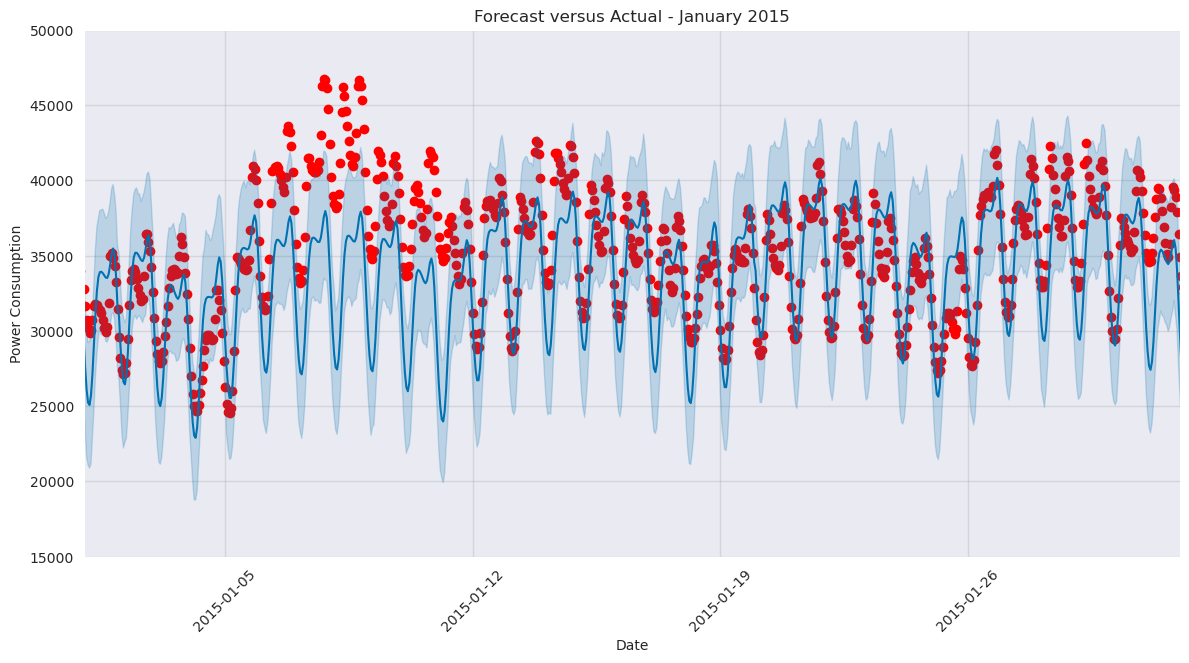

In [27]:
# Set the figure size and layout
fig, axes = plt.subplots(1, figsize=(12, 6))
sns.set_style("darkgrid")

# Plot the power consumption of the test dataset over time
axes.scatter(x=test_df.index, y=test_df["PJME_MW"], color="r")

# Plot the forecasted power consumption
plot_forecast = model.plot(forecast, ax=axes)

# Set labels and title
plt.title("Forecast versus Actual - January 2015")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.xticks(rotation=45)

# Set a limit to the x and y axes
axes.set_xbound(lower=pd.to_datetime("2015-01-01"),
              upper=pd.to_datetime("2015-02-01"))
axes.set_ylim(15000, 50000)

# Display the plot
plt.show()

Based on the figure above, it can be determined that the power consumption around 8 to 9 January was underestimated. After further investigation, it appears that during this period there was a blizzard in America. In general, the model underestimates power consumption more often than it overestimates it.

In [28]:
# Calculate the RMSE and MAE for the test dataset
rmse = round(mean_squared_error(test_df["PJME_MW"], forecast["yhat"], squared=False), 3)
mae = round(mean_absolute_error(test_df["PJME_MW"], forecast["yhat"]), 3)

# Print the evaluation metrics
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 3807.945, MAE: 2961.705
